## Now we will load DESeq2 and perform PCA and differential expression

In [1]:
library("DESeq2")
library("ggplot2")
library("RColorBrewer")


Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The followin

In [3]:
# because DESeq2 works with matrices and uses row names as identifies we load our data accordingly
counts <- read.csv('/home/ucsd-train48/scratch/featureCounts/counts_for_deseq2.csv', header=TRUE, row.names=1)
counts$Length <- NULL
head(counts)


,X.home.ucsd.train48.scratch.star_alignment.DMSO_1_ATCACGAligned.out.sorted.bam,X.home.ucsd.train48.scratch.star_alignment.DMSO_2_CGATGTAligned.out.sorted.bam,X.home.ucsd.train48.scratch.star_alignment.DTP_1_CAGATCAligned.out.sorted.bam,X.home.ucsd.train48.scratch.star_alignment.DTP_2_CCGTCCAligned.out.sorted.bam,X.home.ucsd.train48.scratch.star_alignment.DTP_3_GTGAAAAligned.out.sorted.bam
ENSG00000223972.4,0,0,0,0,0
ENSG00000227232.4,16,19,44,38,61
ENSG00000243485.2,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0
ENSG00000268020.2,0,0,0,0,0
ENSG00000240361.1,0,0,0,0,0


In [4]:
# we also need our condition identifiers so DESeq2 know what to compare against what
condition <- factor(c("DMSO","DMSO","DTP","DTP","DTP"))

Using our featurecounts processed data we don't have to do any data normalization since DESeq2 will do that for us. Instead we only have to format our data so DESeq2 can analyze it. More analysis details can be found in the [example page](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) of DESeq2.

First, we will define experimental parameters. If using a counts matrix, we will use the following function, where countData is equal to our counts matrix ("counts"), colData is equal to our conditions, and design accounts for how we wish to model our effect (in this case, by the "condition" or treatment with a specific drug or shRNA). The factor variable, in this case condition, needs to be columns of coldata:

In [6]:
dds <- DESeqDataSetFromMatrix(countData = counts, colData = DataFrame(condition), design = ~ condition)

In [7]:
#dds <- dds[ rowSums(counts(dds)) > 4, ]

In [8]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [16]:
res <- results(dds)
write.csv(as.data.frame(res), file="/home/ucsd-train48/scratch/featureCounts/differential_expression.csv")
summary(res)



out of 36736 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6117, 17%
LFC < 0 (down)     : 6690, 18%
outliers [1]       : 0, 0%
low counts [2]     : 12433, 34%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Taken directly from the documentation: results() extracts a result table from a DESeq analysis giving base means across samples, log2 fold changes, standard errors, test statistics, p-values and adjusted p-values

The function plotMA allows us to plot the log2 fold changes over the mean of normalized counts for all the samples in dds. Points are colored red if the adjusted p value (alpha) is less than 0.1. Points which fall out of the window are plotted as open triangles pointing either up or down. The window can be widened using the ylim argument

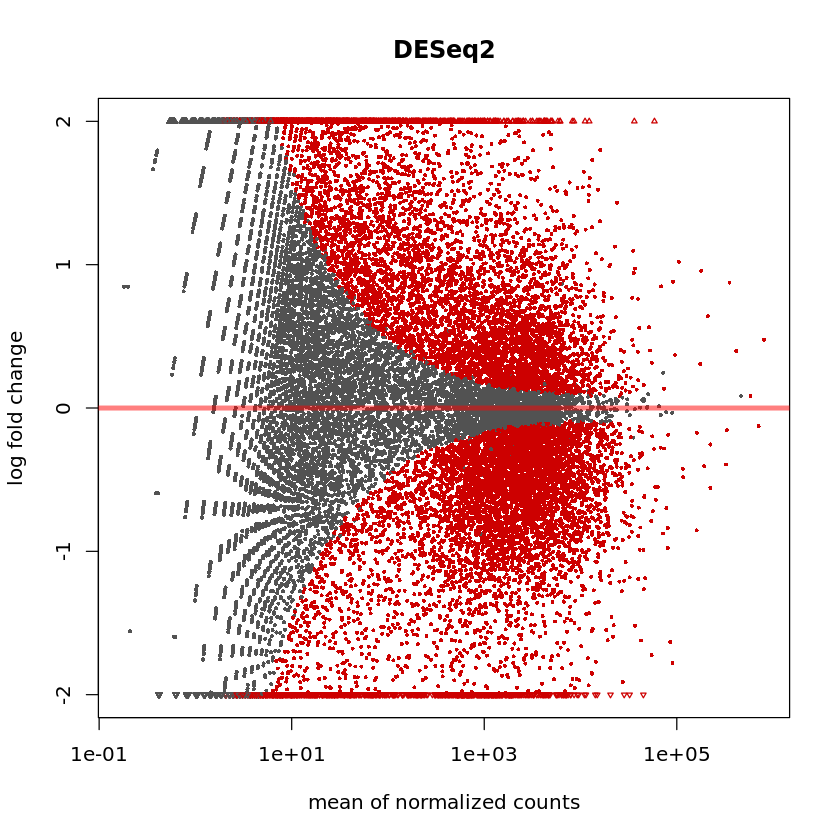

In [12]:
plotMA(res, main="DESeq2", ylim=c(-2,2))


We can also get a more stringent view of our differentially expressed genes by rerunning result on dds with an additional argument alpha. This allows us to be more discerning with our adjusted p value threshold, in this case allowing us to decrease the cutoff to alpha=0.05

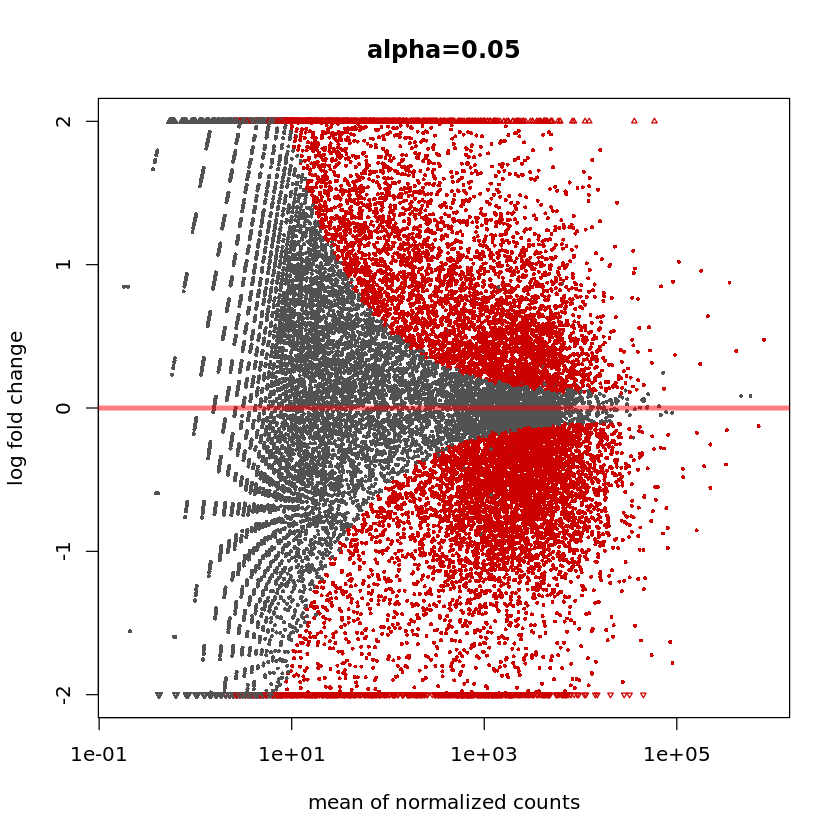

In [13]:
res05 <- results(dds, alpha=0.05)
plotMA(res05, main="alpha=0.05", ylim=c(-2,2))



Let's graph our individual samples using Principal Component Analysis (PCA). This allows us to assess overall variance within our experiment by defining principal components. This plot shows our samples in a 2D plane spanned by their first two principal components. This is useful for visualizing the overall effect of experimental covariates, in this case shRNA treatment, as well as batch effects that may confound findings. For a more thorough explanation of PCA, please refer to this [notebook](https://github.com/biom262/biom262-2019/blob/master/Module_2/Tutorials/Intro_to_PCA.ipynb) in the Tutorials folder.

$y
[1] "PC2: 0% variance"

attr(,"class")
[1] "labels"

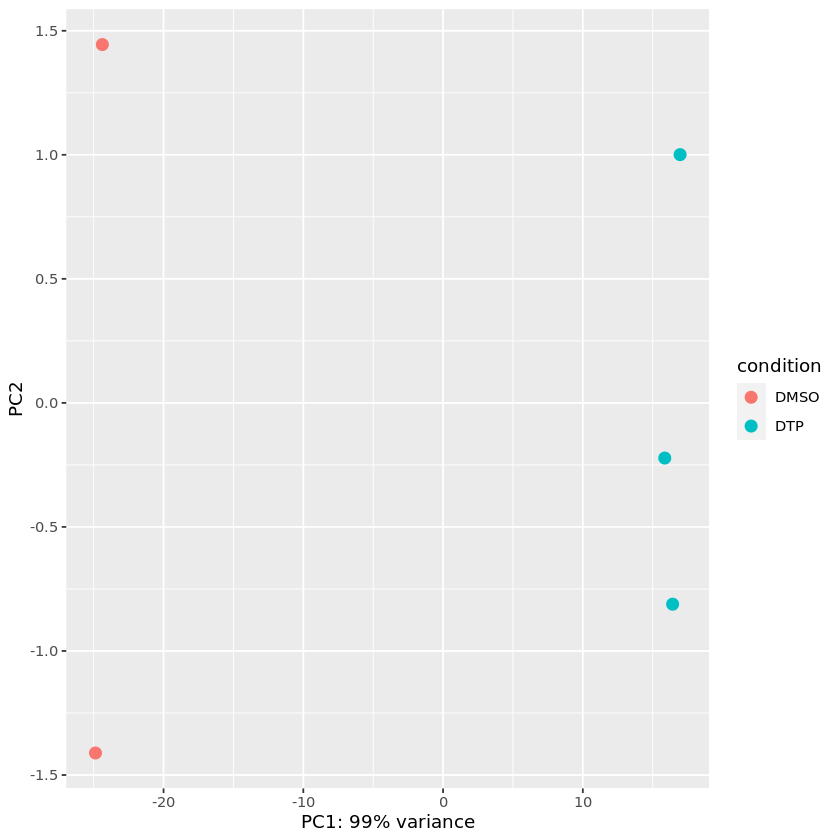

In [14]:
rld <- rlog(dds) 
vsd <- varianceStabilizingTransformation(dds)
data <- plotPCA(rld, intgroup="condition", returnData=TRUE) 
percentVar <- round(100 * attr(data, "percentVar")) 
ggplot(data, aes(PC1, PC2, color=condition)) + geom_point(size=3) + xlab(paste0("PC1: ",percentVar[1],"% variance")) 
ylab(paste0("PC2: ",percentVar[2],"% variance"))


As we can see, 99% of variance at the gene level is attibutable to PC1, along which our experimental conditions cluster separately. Thus, we have reasonably high confidence that out treatment is the main source of variance in our experiment.

Similarly, this can also be visualized via heatmap, which summarizes sample-to-sample similarities via hierarchical clustering:

Warning message in plot.window(...):
“"clustering_distance_rows" is not a graphical parameter”Warning message in plot.window(...):
“"clustering_distance_cols" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"clustering_distance_rows" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"clustering_distance_cols" is not a graphical parameter”Warning message in title(...):
“"clustering_distance_rows" is not a graphical parameter”Warning message in title(...):
“"clustering_distance_cols" is not a graphical parameter”

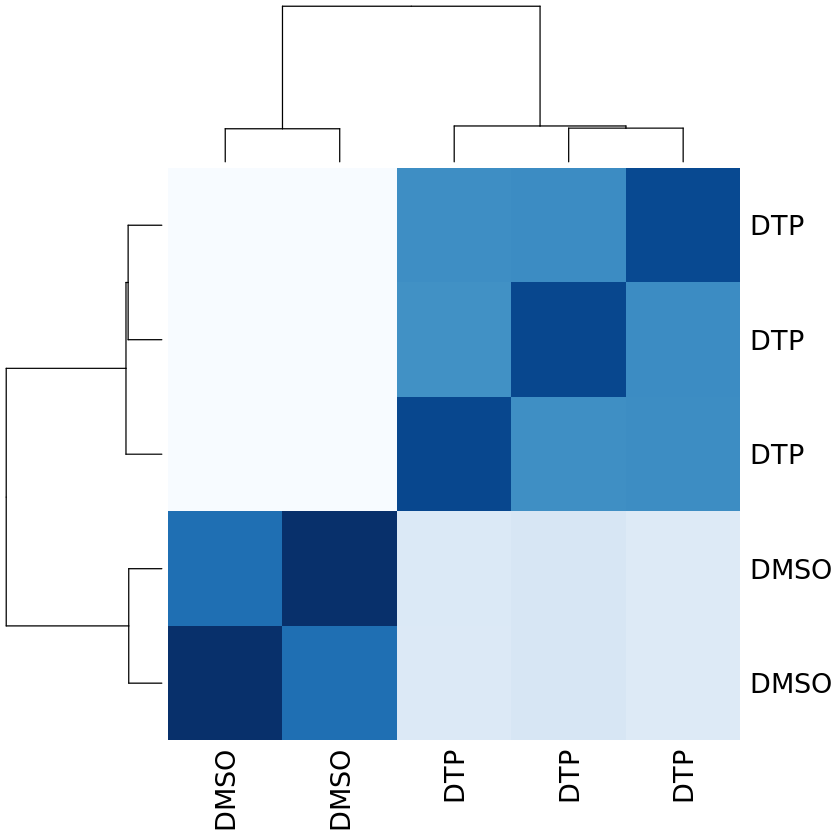

In [15]:
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(rld$condition)
colnames(sampleDistMatrix) <- paste(rld$condition)
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
heatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, col=colors)
